In [12]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt

## Charger les données

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/database_video.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

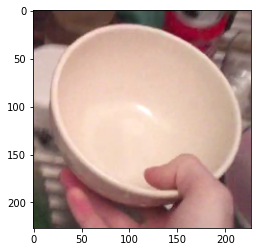

In [15]:
im = Image.open('/tmp/DB/test/Bowl/BowlPlace6Subject4_2_bboxes_157_0.png')
plt.imshow(im)

In [16]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    '/tmp/DB/train', labels='inferred', label_mode='categorical',
    image_size=(im.width, im.height), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    '/tmp/DB/test', labels='inferred', label_mode='categorical',
    image_size=(im.width, im.height), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 4736 files belonging to 5 classes.
Found 3568 files belonging to 5 classes.


## Data augmentation

In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory('/tmp/DB/train', batch_size = 20, class_mode = 'categorical', target_size = (im.width, im.height))
test_generator = test_datagen.flow_from_directory('/tmp/DB/test',  batch_size = 20, class_mode = 'categorical', target_size = (im.width, im.height))

Found 4736 images belonging to 5 classes.
Found 3568 images belonging to 5 classes.


## VGG

In [19]:
base_model = VGG16(input_shape = (im.width, im.height, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
    
x = tfl.Flatten()(base_model.output)
x = tfl.Dense(512, activation='relu')(x)
x = tfl.Dropout(0.5)(x)
out = tfl.Dense(5, activation='softmax')(x)


vgg_model = Model(base_model.input, out)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
logdir = "logs/monmodel"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

vgg_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=[
                    'accuracy', 
                    'categorical_accuracy',
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.Precision()])

vgghist = vgg_model.fit(train_generator, validation_data = test_generator, steps_per_epoch = 100, epochs = 10, callbacks=[tensorboard_callback])

Epoch 1/10
  1/100 [..............................] - ETA: 0s - loss: 1.7393 - accuracy: 0.3500 - categorical_accuracy: 0.3500 - recall: 0.0500 - precision: 0.1667WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 23/100 [=====>........................] - ETA: 12:39 - loss: 1.8610 - accuracy: 0.3630 - categorical_accuracy: 0.3630 - recall: 0.2348 - precision: 0.3899

In [ ]:
vgghist.history

{'loss': [1.5324680805206299, 0.1829884648323059],
 'accuracy': [0.8974999785423279, 0.978515625],
 'val_loss': [1.334412693977356, 1.1849209070205688],
 'val_accuracy': [0.8960201740264893, 0.8940582871437073]}